In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [ ]:
# Transform: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 40.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.10MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.97MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.87MB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(z.size(0), 1, 28, 28)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

adversarial_loss = nn.BCELoss()


[Epoch 1/5] D loss: 0.0762, G loss: 2.8438


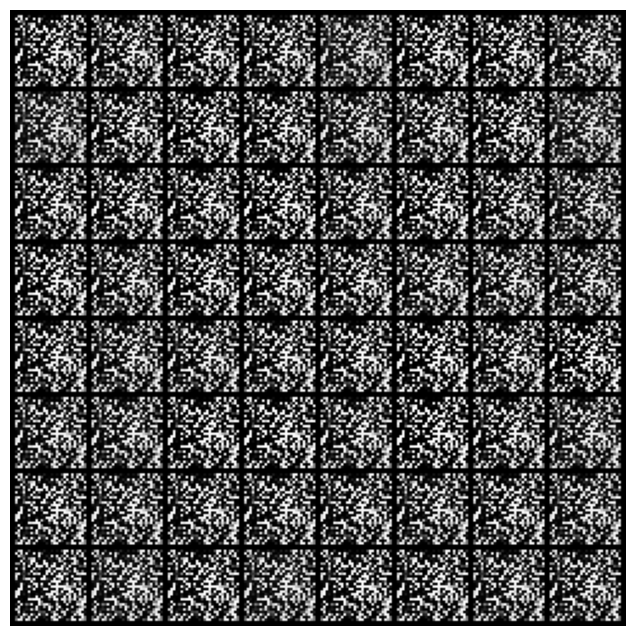

[Epoch 2/5] D loss: 0.0127, G loss: 5.3558


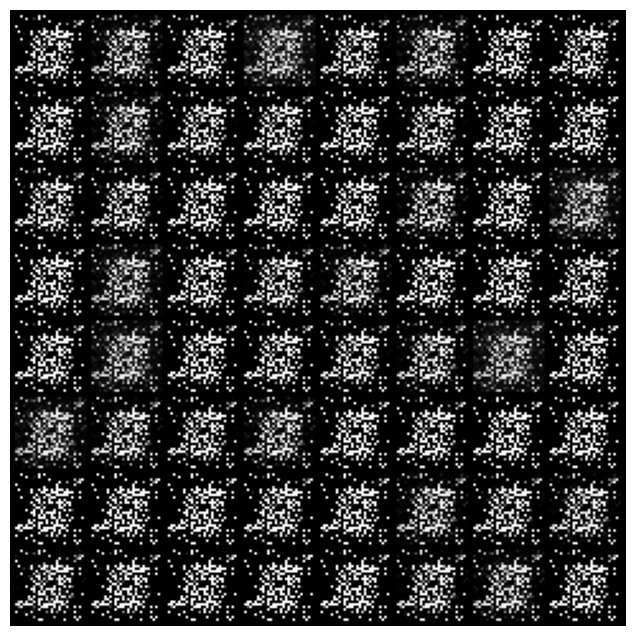

[Epoch 3/5] D loss: 0.0278, G loss: 7.4816


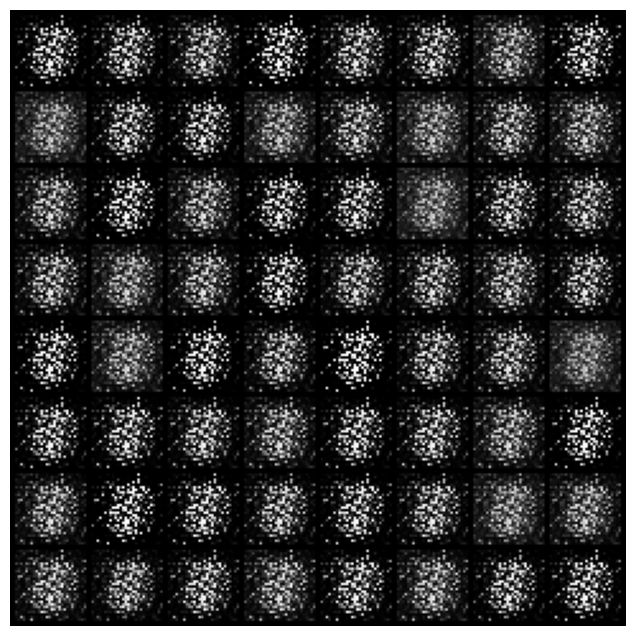

[Epoch 4/5] D loss: 0.1444, G loss: 2.7424


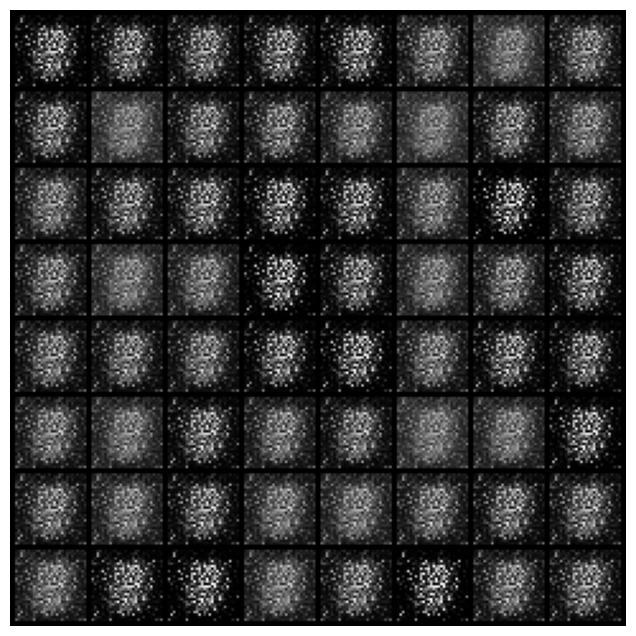

[Epoch 5/5] D loss: 0.3687, G loss: 2.4857


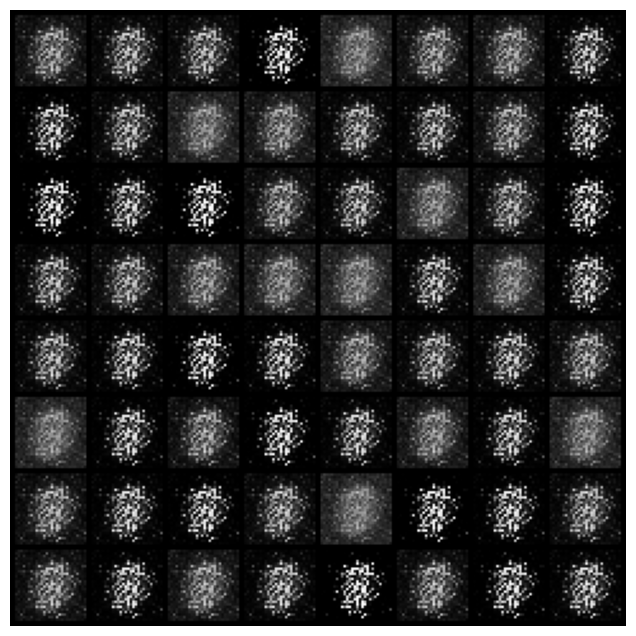

In [ ]:
import torchvision.utils as vutils

epochs = 5  # or more if you want
sample_interval = 1  # visualize every 1 epoch

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        batch_size = imgs.size(0)
        real_imgs = imgs.to(device)

        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        # Train Generator
        # ---------------------
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch+1}/{epochs}] D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")

    # ---------------------
    # Visualize generated digits
    # ---------------------
    if (epoch + 1) % sample_interval == 0:
        generator.eval()
        with torch.no_grad():
            z = torch.randn(64, latent_dim).to(device)
            gen_imgs = generator(z)
            grid = vutils.make_grid(gen_imgs, nrow=8, normalize=True)
            plt.figure(figsize=(8,8))
            plt.imshow(grid.permute(1, 2, 0).cpu())
            plt.axis('off')
            plt.show()
        generator.train()


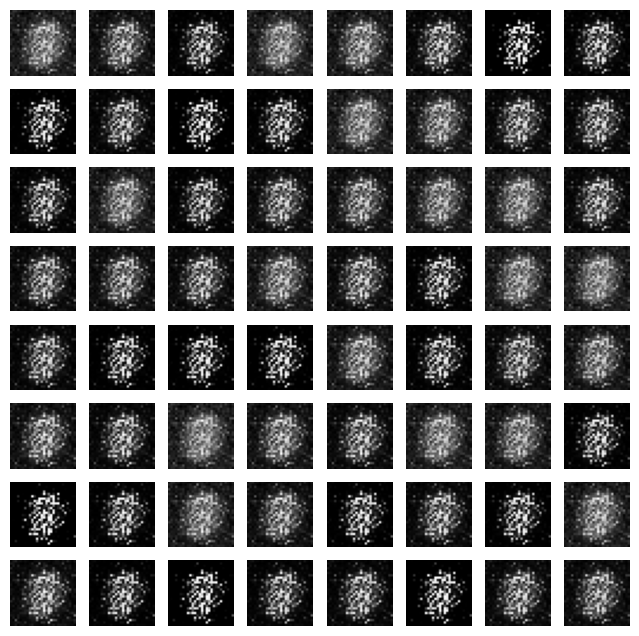

In [ ]:
generator.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    gen_imgs = generator(z).cpu()
    plt.figure(figsize=(8,8))
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.imshow(gen_imgs[i].view(28,28), cmap='gray')
        plt.axis('off')
    plt.show()
